In [1]:
%load_ext autoreload
%autoreload 2

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pytensor.tensor as pt

from tqdm import trange

import pymc as pm

In [65]:
with pm.Model() as m:
    X = pm.Normal("X", 0, 1, size=(100, 10))
    alpha = pm.Normal("alpha", 100, 10)
    beta = pm.Normal("beta", 0, 5, size=(10,))

    mu = alpha + X @ beta
    sigma = pt.expit(pm.Normal("sigma", 0, 1))
    y = pm.Normal("y", mu=mu, sigma=sigma)

    prior = pm.sample_prior_predictive(random_seed=37)

Sampling: [X, alpha, beta, sigma, y]


In [66]:
prior.prior.sigma.sel(chain=0, draw=123)

<xarray.DataArray 'sigma' ()> Size: 8B
array(-0.51654208)
Coordinates:
    chain    int64 8B 0
    draw     int64 8B 123

In [67]:
draw = 123
true_params = np.r_[
    prior.prior.alpha.sel(chain=0, draw=draw).values,
    prior.prior.beta.sel(chain=0, draw=draw),
    prior.prior.sigma.sel(chain=0, draw=draw),
]
X_data = prior.prior.X.sel(chain=0, draw=draw).values
y_data = prior.prior.y.sel(chain=0, draw=draw).values

In [68]:
true_params

array([105.36779765,  -2.05755013,  -3.59076726,   3.39803993,
         7.06099911,  -4.27716327,  -3.11450432,  -2.94968068,
         0.91650485,   7.0978996 ,  -0.16072518,  -0.51654208])

In [69]:
m_obs = pm.observe(pm.do(m, {X: X_data}), {"y": y_data})

In [31]:
# Parameter = pt.tensor
# draws = pt.tensor("draws", shape=(), dtype="int64")

# with pm.Model() as guide_model:
#     X = pm.Data("X", X_data)
#     alpha_loc = Parameter("alpha_loc", shape=())
#     alpha_scale = Parameter("alpha_scale", shape=())
#     alpha_z = pm.Normal("alpha_z", mu=0, sigma=1, shape=(draws,))
#     alpha = pm.Deterministic("alpha", alpha_loc + alpha_scale * alpha_z)

#     beta_loc = Parameter("beta_loc", shape=(10,))
#     beta_scale = Parameter("beta_scale", shape=(10,))
#     beta_z = pm.Normal("beta_z", mu=0, sigma=1, shape=(draws, 10))
#     beta = pm.Deterministic("beta", beta_loc + beta_scale * beta_z)

#     mu = alpha + X @ beta

#     sigma_loc = Parameter("sigma_loc", shape=())
#     sigma_scale = Parameter("sigma_scale", shape=())
#     sigma_z = pm.Normal("sigma_z", 0, 1, shape=(draws,))
#     sigma = pm.Deterministic("sigma", pt.softplus(sigma_loc + sigma_scale * sigma_z))

# # with pm.Model() as guide_model2:
# #     n = 10 + 1 + 1
# #     loc = Parameter("loc", shape=(n,))
# #     chol_flat = Parameter("chol", shape=(n * n-1, ))
# #     chol = pm.expand_packed_triangular(n, chol_flat)
# #     latent_mvn = pm.MvNormal("latent_mvn", chol=chol)

# #     pm.Deterministic("beta", latent_mvn[:10])
# #     pm.Deterministic("alpha", latent_mvn[10])
# #     pm.Deterministic("sigma", pm.math.exp(latent_mvn[11]))

In [32]:
# params = [alpha_loc, alpha_scale, beta_loc, beta_scale, sigma_loc, sigma_scale]

In [70]:
from pymc.variational.autoguide import AutoDiagonalNormal

generated_guide_model = AutoDiagonalNormal(m_obs)

In [71]:
# pytensor.dprint(tuple(generated_guide_model.model.named_vars.values()))

In [72]:
generated_guide_model.params_init_values

{sigma_loc: array(0.36912096),
 sigma_scale: array(0.1),
 beta_loc: array([-0.38476868, -0.64897423,  0.57357738, -0.9794639 , -0.06013771,
         0.3815328 ,  0.97659979, -0.71657823, -0.54865333,  0.25146485]),
 beta_scale: array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]),
 alpha_loc: array(0.09282113),
 alpha_scale: array(0.1)}

In [73]:
from pytensor.graph.replace import graph_replace, vectorize_graph

draws = generated_guide_model.draws
params = generated_guide_model.params

guide_model = generated_guide_model.model
value_vars_to_guide_vars = {m_obs.rvs_to_values[rv]: guide_model[rv.name] for rv in m_obs.free_RVs}
model_logp = vectorize_graph(m_obs.logp(), value_vars_to_guide_vars)
guide_logq = graph_replace(guide_model.logp(), guide_model.values_to_rvs)

negative_elbo = (guide_logq - model_logp).mean()
d_loss = pt.grad(negative_elbo, params)

f_loss_dloss = pm.compile(
    [draws, *params], [negative_elbo, *d_loss], trust_input=True, mode="NUMBA"
)

In [74]:
# model_logp.dprint()

In [75]:
f_loss_dloss(np.array(500, dtype=int), *generated_guide_model.params_init_values.values())

[array(2481097.35044027),
 array(-2855161.77882372),
 array(2132764.05291032),
 array([-2995.08629308,   329.04991906, -5076.78140574, -2265.52469619,
        -4203.02209084,   -33.45408885,  -542.83555528,  7404.63553771,
        -5291.17816764,  3597.45657235]),
 array([132.7696106 , 200.81604838, 110.39763571,  61.9496137 ,
        266.24921404, 145.88311937, 179.68441005,  93.75234921,
        112.47121256, 449.71910922]),
 array(-46954.79140267),
 array(-2583.94605728)]

In [77]:
1e-3 / 10 / 10

1e-05

In [80]:
init_param_values = generated_guide_model.params_init_values
opt_param_values = list(init_param_values.values())
learning_rate = 1e-3
n_iter = 50_000
loss_history = np.empty(n_iter)
progress_bar = trange(n_iter)
draws = np.array(100, dtype=int)
for i in progress_bar:
    loss, *grads = f_loss_dloss(draws, *opt_param_values)
    loss_history[i] = loss
    opt_param_values = [
        np.asarray(value - learning_rate * grad) for value, grad in zip(opt_param_values, grads)
    ]
    if i % 50 == 0:
        progress_bar.set_description(f"Loss: {loss:.2f}")
    if i % 5_000 == 0 and i > 0:
        learning_rate = max(learning_rate / 5, 1e-5)

optimized_params = {k.name: v for k, v in zip(init_param_values, opt_param_values)}
optimized_params

Loss: -1645.31: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:49<00:00, 1004.03it/s]


{'sigma_loc': array(-0.49372324),
 'sigma_scale': array(-1187.5481976),
 'beta_loc': array([-2.06671465, -3.6072864 ,  3.36634662,  7.02986644, -4.34636197,
        -3.1305346 , -2.93636488,  0.89842266,  7.10260868, -0.1068411 ]),
 'beta_scale': array([-4.65667569, -4.64571998, -4.54605105, -4.57467071, -4.54443722,
        -4.45440426, -4.62193477, -4.60320444, -4.48511702, -4.51610615]),
 'alpha_loc': array(105.34737823),
 'alpha_scale': array(-5.47036345)}

In [81]:
learning_rate

1e-05

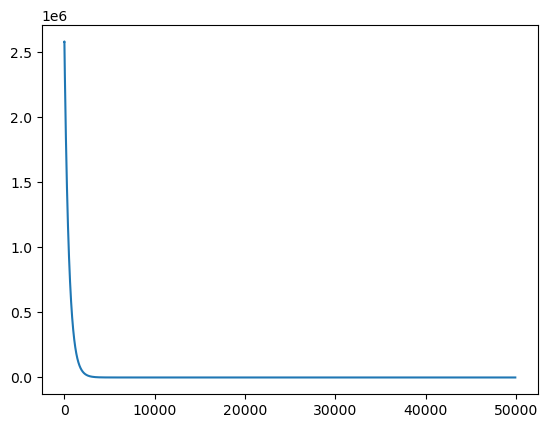

In [82]:
window_size = 100
kernel = np.full(window_size, 1 / window_size)
plt.plot(np.convolve(loss_history, kernel, mode="valid"))

In [49]:
learning_rate

1e-05

In [83]:
n_iter = 10_000
loss_history = np.empty(n_iter)
progress_bar = trange(n_iter)
draws = np.array(500, dtype=int)
learning_rate = 1e-5
for i in progress_bar:
    loss, *grads = f_loss_dloss(draws, *opt_param_values)
    loss_history[i] = loss
    opt_param_values = [
        np.asarray(value - learning_rate * grad) for value, grad in zip(opt_param_values, grads)
    ]
    if i % 50 == 0:
        progress_bar.set_description(f"Loss: {loss:.2f}")

optimized_params = {k.name: v for k, v in zip(init_param_values, opt_param_values)}
optimized_params

Loss: -8456.47: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 536.16it/s]


{'sigma_loc': array(-0.4938194),
 'sigma_scale': array(-1187.5481976),
 'beta_loc': array([-2.06660193, -3.60731005,  3.36643533,  7.02987778, -4.34634069,
        -3.13052706, -2.93636157,  0.89847751,  7.10262408, -0.106888  ]),
 'beta_scale': array([-4.66408299, -4.65312909, -4.55346696, -4.58206233, -4.55184415,
        -4.46184418, -4.62933992, -4.61059266, -4.49253168, -4.5235085 ]),
 'alpha_loc': array(105.34736046),
 'alpha_scale': array(-5.4715881)}

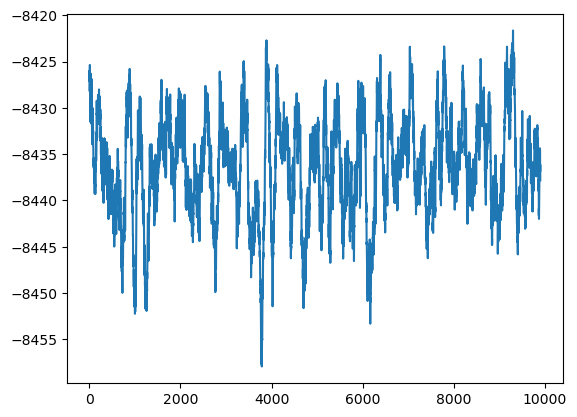

In [84]:
window_size = 100
kernel = np.full(window_size, 1 / window_size)
plt.plot(np.convolve(loss_history, kernel, mode="valid"))

In [85]:
optimized_params

{'sigma_loc': array(-0.4938194),
 'sigma_scale': array(-1187.5481976),
 'beta_loc': array([-2.06660193, -3.60731005,  3.36643533,  7.02987778, -4.34634069,
        -3.13052706, -2.93636157,  0.89847751,  7.10262408, -0.106888  ]),
 'beta_scale': array([-4.66408299, -4.65312909, -4.55346696, -4.58206233, -4.55184415,
        -4.46184418, -4.62933992, -4.61059266, -4.49253168, -4.5235085 ]),
 'alpha_loc': array(105.34736046),
 'alpha_scale': array(-5.4715881)}

In [86]:
true_params

array([105.36779765,  -2.05755013,  -3.59076726,   3.39803993,
         7.06099911,  -4.27716327,  -3.11450432,  -2.94968068,
         0.91650485,   7.0978996 ,  -0.16072518,  -0.51654208])

In [87]:
np.set_printoptions(suppress=True)
opt_params_flat = np.r_[
    optimized_params["alpha_loc"], optimized_params["beta_loc"], optimized_params["sigma_loc"]
]
opt_params_flat

array([105.34736046,  -2.06660193,  -3.60731005,   3.36643533,
         7.02987778,  -4.34634069,  -3.13052706,  -2.93636157,
         0.89847751,   7.10262408,  -0.106888  ,  -0.4938194 ])

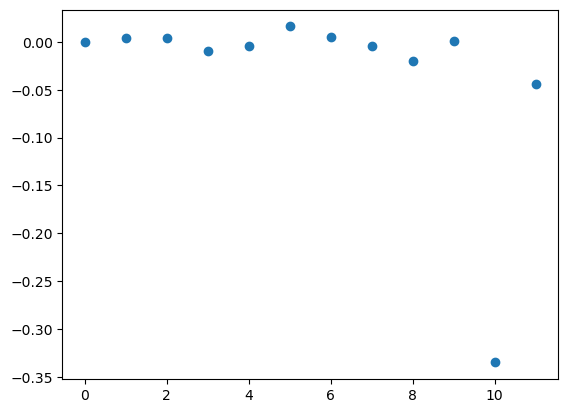

In [88]:
plt.scatter(np.arange(len(true_params)), (opt_params_flat - true_params) / true_params)

## Todo:

- Do we just constrain parameters? Anything else needed?
- Does this "two models" frameworks fits into what we already have?
- `model_to_mean_field` transformation
- rsample --> stochastic gradients? Or automatic reparameterization?
- figure out guide param initalization
- More flexible optimizers...